In [245]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import feature, exposure
from matplotlib.pyplot import bar
from skimage.transform import resize
#import imutils
from PIL import Image, ImageEnhance

In [168]:
#https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
#https://cvexplained.wordpress.com/2020/07/22/10-7-local-binary-patterns/
#numPoints=24, radius=8
def LocalBinaryPatterns(image, eps=1e-7,numPoints=16, radius=2):
    # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        #https://scikit-image.org/docs/dev/api/skimage.feature.html#local-binary-pattern
        #'uniform', the result only includes patterns where all black dots are adjacent and all white dots are adjacent. All other combinations are labeled 'non-uniform'.
        #Non-uniform results: If you look at your result more closely, there are actually 243 bins, not 242. The 243th bin lumps together all non-uniform results.
        lbp = feature.local_binary_pattern(image, numPoints,radius, method='nri_uniform')
        pinnum=lbp.ravel().max()
        (hist, edges) = np.histogram(lbp.ravel(),bins=np.arange(0,pinnum))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist,edges

In [169]:
def showHist(hist,edges):
    fig, ax = plt.subplots()
    ax.bar(edges[:-1], hist, width=np.diff(edges), edgecolor="red", align="edge")
    plt.show()

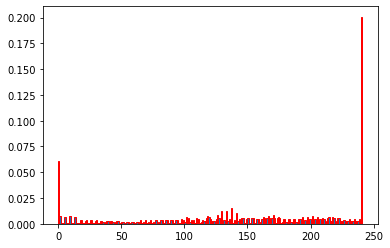

In [170]:
imagePath='HR.JPG'
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hist,edges = LocalBinaryPatterns(gray)
showHist(hist,edges)

In [237]:
#https://mulloverthings.com/how-do-you-extract-hog-features-in-python/
def HistogramofOrientedGradients(image):
    resized_img = resize(image, (128, 64))
    print(resized_img.shape)
    fd, hog_image = feature.hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    #print(fd[:11].sum())
    print(hog_image.shape)
    #pinnum=fd.max()
    #(hist, edges) = np.histogram(fd,bins=np.arange(0,pinnum))
    # Rescale histogram for better display
    plt.hist(fd,fd.shape[0],[0,1]);
    plt.show()

    plt.imshow(hog_image, cmap="gray")

(128, 64, 3)
1.0113167151465858


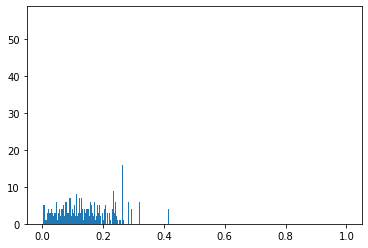

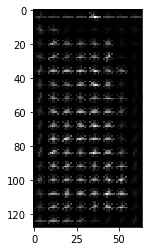

In [238]:
imagePath='HR.JPG'
image = cv2.imread(imagePath)
HistogramofOrientedGradients(image)

In [239]:
N_RHO_BINS = 7
N_ANGLE_BINS = 12
N_BINS = N_RHO_BINS * N_ANGLE_BINS
BIN_SIZE = 360 // N_ANGLE_BINS
R_INNER = 5.0
R_OUTER = 35.0
K_S = np.arange(3, 8)

In [246]:
def preprocess_image(img_file,show_images=True,sharpness_factor = 10, bordersize = 3,):
        im = Image.open(img_file)
        
        enhancer = ImageEnhance.Sharpness(im)
        im_s_1 = enhancer.enhance(sharpness_factor)
        # plt.imshow(im_s_1, cmap='gray')
        # double the size of the image
        (width, height) = (im.width * 2, im.height * 2)
        im_s_1 = im_s_1.resize((width, height))
        
        if show_images: plt.imshow(im_s_1, cmap='gray')
        image = np.array(im_s_1)
        image = cv2.copyMakeBorder(
            image,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv2.BORDER_CONSTANT,
            value=[255, 255, 255]
        )
        orig_image = image.copy()
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.GaussianBlur(image,(3,3),0)
        if show_images: plt.imshow(image, cmap='gray')
        (thresh, bw_image) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        if show_images: plt.imshow(bw_image, cmap='gray')
        return bw_image, orig_image

In [247]:
def get_contour_pixels(bw_image,show_images=True):
        contours, _= cv2.findContours(
            bw_image, cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_NONE
            ) 
        # contours = imutils.grab_contours(contours)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
        
        # newaxise to incease the dimantion
        img2 = bw_image.copy()[:,:,np.newaxis]
        img2 = np.concatenate([img2, img2, img2], axis = 2)
        if show_images:
            for cnt in contours : 
                cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 1)  
                
            plt.imshow(img2, cmap='gray')
        return contours

In [248]:
def get_cold_features(img_file, approx_poly_factor = 0.01):
        bw_image, _ = preprocess_image(img_file)
        contours = get_contour_pixels(bw_image)
        
        rho_bins_edges = np.log10(np.linspace(R_INNER, R_OUTER, N_RHO_BINS))
        feature_vectors = np.zeros((len(K_S), N_BINS))
        
        # print([len(cnt) for cnt in contours])
        for j, k in enumerate(K_S):
            hist = np.zeros((N_RHO_BINS, N_ANGLE_BINS))
            for cnt in contours:
                epsilon = approx_poly_factor * cv2.arcLength(cnt,True)
                cnt = cv2.approxPolyDP(cnt,epsilon,True)
                n_pixels = len(cnt)
                
                point_1s = np.array([point[0] for point in cnt])
                x1s, y1s = point_1s[:, 0], point_1s[:, 1]
                point_2s = np.array([cnt[(i + k) % n_pixels][0] for i in range(n_pixels)])
                x2s, y2s = point_2s[:, 0], point_2s[:, 1]
                
                thetas = np.degrees(np.arctan2(y2s - y1s, x2s - x1s) + np.pi)
                rhos = np.sqrt((y2s - y1s) ** 2 + (x2s - x1s) ** 2)
                rhos_log_space = np.log10(rhos)
                
                quantized_rhos = np.zeros(rhos.shape, dtype=int)
                for i in range(N_RHO_BINS):
                    quantized_rhos += (rhos_log_space < rho_bins_edges[i])
                    
                for i, r_bin in enumerate(quantized_rhos):
                    theta_bin = int(thetas[i] // BIN_SIZE) % N_ANGLE_BINS
                    hist[r_bin - 1, theta_bin] += 1
                
            normalised_hist = hist / hist.sum()
            feature_vectors[j] = normalised_hist.flatten()
            
        return feature_vectors.flatten()

C:\Users\Raghod\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


(420,)


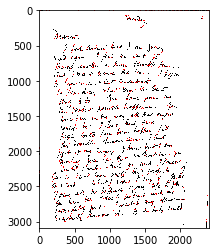

In [251]:
imagePath='HR.JPG'
features=get_cold_features(imagePath)
print(features.shape)

In [ ]:
import imutils
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
import numpy as np

N_RHO_BINS = 7
N_ANGLE_BINS = 12
N_BINS = N_RHO_BINS * N_ANGLE_BINS
BIN_SIZE = 360 // N_ANGLE_BINS
R_INNER = 5.0
R_OUTER = 35.0
K_S = np.arange(3, 8)

class Cold():
    def __init__(self, opt):
        self.sharpness_factor = opt.sharpness_factor
        self.bordersize = opt.bordersize
        self.show_images = opt.show_images
        self.is_binary = opt.is_binary
        
    def preprocess_binary_image(self, img_file, sharpness_factor = 10, bordersize = 3):
        im = Image.open(img_file)
        
        #An enhancement factor of 0.0 gives a blurred image, a factor of 1.0 gives the original image, and a factor of 2.0 gives a sharpened image.
        enhancer = ImageEnhance.Sharpness(im)
        im_s_1 = enhancer.enhance(sharpness_factor)
        # plt.imshow(im_s_1, cmap='gray')
        # black->white & white ->black
        image = 255 - np.array(im_s_1)
        
        #add white border around the image
        bw_image = cv2.copyMakeBorder(
            image,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv2.BORDER_CONSTANT,
            value=[255]
        )
        return bw_image, image
    
    def preprocess_image(self, img_file, sharpness_factor = 10, bordersize = 3):
        im = Image.open(img_file)
        
        enhancer = ImageEnhance.Sharpness(im)
        im_s_1 = enhancer.enhance(sharpness_factor)
        # plt.imshow(im_s_1, cmap='gray')
        # double the size of the image
        (width, height) = (im.width * 2, im.height * 2)
        im_s_1 = im_s_1.resize((width, height))
        
        if self.show_images: plt.imshow(im_s_1, cmap='gray')
        image = np.array(im_s_1)
        image = cv2.copyMakeBorder(
            image,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv2.BORDER_CONSTANT,
            value=[255, 255, 255]
        )
        orig_image = image.copy()
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.GaussianBlur(image,(3,3),0)
        if self.show_images: plt.imshow(image, cmap='gray')
        (thresh, bw_image) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        if self.show_images: plt.imshow(bw_image, cmap='gray')
        return bw_image, orig_image

    def get_contour_pixels(self, bw_image):
        contours, _= cv2.findContours(
            bw_image, cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_NONE
            ) 
        # contours = imutils.grab_contours(contours)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
        
        # newaxise to incease the dimantion
        img2 = bw_image.copy()[:,:,np.newaxis]
        img2 = np.concatenate([img2, img2, img2], axis = 2)
        if self.show_images:
            for cnt in contours : 
                cv2.drawContours(img2, [cnt], 0, (255, 0, 0), 1)  
                
            plt.imshow(img2, cmap='gray')
        return contours
    
    def get_cold_features(self, img_file, approx_poly_factor = 0.01):
        if self.is_binary:
            bw_image, _ = self.preprocess_binary_image(img_file, self.sharpness_factor, self.bordersize)
        else:
            bw_image, _ = self.preprocess_image(img_file, self.sharpness_factor, self.bordersize)
        contours = self.get_contour_pixels(bw_image)
        
        rho_bins_edges = np.log10(np.linspace(R_INNER, R_OUTER, N_RHO_BINS))
        feature_vectors = np.zeros((len(K_S), N_BINS))
        
        # print([len(cnt) for cnt in contours])
        for j, k in enumerate(K_S):
            hist = np.zeros((N_RHO_BINS, N_ANGLE_BINS))
            for cnt in contours:
                epsilon = approx_poly_factor * cv2.arcLength(cnt,True)
                cnt = cv2.approxPolyDP(cnt,epsilon,True)
                n_pixels = len(cnt)
                
                point_1s = np.array([point[0] for point in cnt])
                x1s, y1s = point_1s[:, 0], point_1s[:, 1]
                point_2s = np.array([cnt[(i + k) % n_pixels][0] for i in range(n_pixels)])
                x2s, y2s = point_2s[:, 0], point_2s[:, 1]
                
                thetas = np.degrees(np.arctan2(y2s - y1s, x2s - x1s) + np.pi)
                rhos = np.sqrt((y2s - y1s) ** 2 + (x2s - x1s) ** 2)
                rhos_log_space = np.log10(rhos)
                
                quantized_rhos = np.zeros(rhos.shape, dtype=int)
                for i in range(N_RHO_BINS):
                    quantized_rhos += (rhos_log_space < rho_bins_edges[i])
                    
                for i, r_bin in enumerate(quantized_rhos):
                    theta_bin = int(thetas[i] // BIN_SIZE) % N_ANGLE_BINS
                    hist[r_bin - 1, theta_bin] += 1
                
            normalised_hist = hist / hist.sum()
            feature_vectors[j] = normalised_hist.flatten()
            
        return feature_vectors.flatten()


if __name__ == '__name__':
    import argparse
    parser = argparse.ArgumentParser(description="")
    parser.add_argument("--img_file", type=str, default=r"IMAGE FILE LOCATION")
    parser.add_argument("--sharpness_factor", type=int, default=10)
    parser.add_argument("--bordersize", type=int, default=3)
    parser.add_argument("--show_images", type=bool, default=False)
    parser.add_argument("--is_binary", type=bool, default=False)
    opt = parser.parse_args()
    
    cold = Cold(opt)
    feature_vectors = cold.get_cold_features(opt.img_file)
    
    print ("shape of feature vector: {}".format(feature_vectors.shape))